In [557]:
%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import skimage.measure
from skimage.measure import label
import os.path
from scipy.ndimage.morphology import binary_erosion

In [590]:
working_dir = "/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/TRAIN/059d8c14b2256a2ba4e38ac511700203/"

In [591]:
mask = np.load(working_dir + "mask.npy")
lung = np.load(working_dir + "lungs.npy")

def separate_lungs(mask):
    left_lung = []
    right_lung = []
    for i in range(mask.shape[0]):
        (labeled, count) = label(mask[i], connectivity=1, return_num=True)
        if count < 2:
            left_lung.append(np.zeros(mask.shape[1:]))
            right_lung.append(np.zeros(mask.shape[1:]))
            continue
        elif count == 2:
            left_slice = labeled.copy()
            left_slice[left_slice == 1] = 0
            left_lung.append(left_slice)
            
            right_slice = labeled.copy()
            right_slice[right_slice == 2] = 0
            right_lung.append(right_slice)
    
    return (np.array(left_lung), np.array(right_lung))

In [592]:
def label_size(labeled_matrix, label): return len(labeled_matrix[labeled_matrix==label])
trash_threshold = 0.5
def remove_trash(labeled_matrix,label_num):
    max_label_size = 0
    new_label_num = 0
    for i in range(1,label_num+1):
        if len(labeled_matrix[labeled_matrix == i]) > max_label_size:
            max_label_size = len(labeled_matrix[labeled_matrix == i])
    for i in range(1,label_num+1):
        if label_size(labeled_matrix,i)<trash_threshold*max_label_size:
            labeled_matrix[labeled_matrix == i] = 0
        else:
            new_label_num += 1
            labeled_matrix[labeled_matrix == i] = new_label_num
    return new_label_num

In [593]:
def separate_lungs(mask):
    label_matrix,count = label(mask, connectivity=1, return_num=True)
    count = remove_trash(label_matrix,count)
    before_morph_open = label_matrix 
    i = 0
    while count==1:
        label_matrix = binary_erosion(label_matrix,structure = np.ones((7,1)))
        label_matrix,count = label(label_matrix, connectivity=1, return_num=True)
        count = remove_trash(label_matrix,count)
    inverse_erosion(label_matrix, before_morph_open)
    return label_matrix

In [594]:
def inverse_erosion(label_matrix, mask):
    xs,ys = np.where(label_matrix<mask)
    border_coords = list(zip(xs,ys))
    while len(border_coords):
        to1 = []
        to2 = []
        new_border_coords = []
        for x,y in border_coords:
            chunk = label_matrix[x-1:x+2,y-1:y+2]
            if len(np.where(chunk==1)[0]):
                to1.append((x,y))
            elif len(np.where(chunk==2)[0]):
                to2.append((x,y))
            else:
                new_border_coords.append((x,y))
        for x,y in to1:
            label_matrix[x,y] = 1
        for x,y in to2:
            label_matrix[x,y] = 2
        border_coords = new_border_coords

<IPython.core.display.Javascript object>


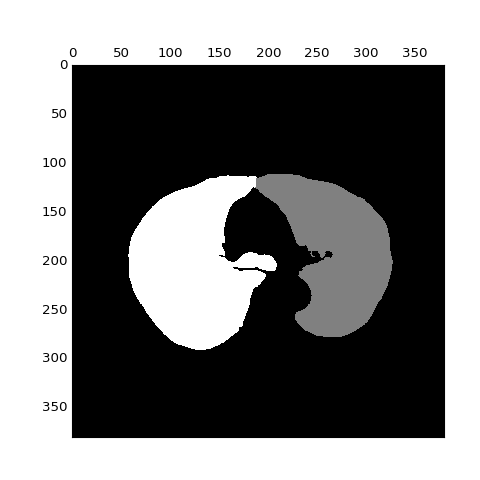

In [595]:
# ct_slice = mask.shape[0] // 2
ct_slice = 120
(labeled, count) = label(mask[ct_slice], connectivity=1, return_num=True)
sepd = separate_lungs(mask[ct_slice])
#labeled[labeled == 1] = 0
plt.matshow(sepd)